# Bright Ocean

A Bright Ocean é uma iniciativa que visa a proteção dos recifes de corais. O intuito deste modelo de visão computacional é identificar novos recifes de corais e monitorar os já catalogados, com o diagnóstico de saúde dos corais para que sejam traçadas estratégias de restauração de recifes ameaçados.

## Integrantes

In [2]:
members = {
    'RM': ['552226', '98676', '551905', '550782', '550813'],
    'Nome': ['Bruno Francisco Brito de Paula', 'Edward de Lima Silva',
             'Gabriel Barroso de Assis França','Kayque Lima Nunes', 'Luana Duque'],
}

group = pd.DataFrame(members)
group.set_index('RM', inplace=True)
group['Turma'] = '2TDSPW'
group

,Nome,Turma
RM,,
552226,Bruno Francisco Brito de Paula,2TDSPW
98676,Edward de Lima Silva,2TDSPW
551905,Gabriel Barroso de Assis França,2TDSPW
550782,Kayque Lima Nunes,2TDSPW
550813,Luana Duque,2TDSPW


# Bibliotecas

Bibliotecas utilizadas para construção do modelo de computação visual.

In [36]:
# Análise e Manipulação de Dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Diretório
import os
import random
from pathlib import Path

# Registro
import datetime

# Scikit-Learn
from sklearn.model_selection import train_test_split

# Tensorflow
import tensorflow
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers,models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau

# Avaliação de modelos
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix

# Exportação do modelo
import pickle

In [2]:
# Funções auxiliares
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

--2024-06-06 03:41:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-06 03:41:24 (59.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



### Setup

Configurando seeds das bibliotecas, para garantir a reproducibilidade do modelo em versões futuras, e configurações do Tensorflow para não utilizar paralelismo durante operações, afim de evitar o não-determinismo.

In [3]:
def seeding(seed=42):

    tensorflow.random.set_seed(seed)
    np.random.seed(seed)

    session_config = tensorflow.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    tensorflow.compat.v1.set_random_seed(seed)
    sess = tensorflow.compat.v1.Session(graph=tensorflow.compat.v1.get_default_graph(), config=session_config)
    tensorflow.compat.v1.keras.backend.set_session(sess)

seeding()

# Dataset

Disponível em: https://www.kaggle.com/datasets/vencerlanz09/healthy-and-bleached-corals-image-classification.

O dataset contém 963 fotografias de corais, sendo 438 de corais saudáveis e 485 de corais branqueados.

In [3]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

## Montando o DataFrame

Criando DataFrame com as imagens.

In [21]:
images = Path('/content/dataset')


filepaths = (list(images.glob(r'**/*.JPG')) +
             list(images.glob(r'**/*.jpg')) +
             list(images.glob(r'**/*.jpeg')) +
             list(images.glob(r'**/*.PNG')))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
labels = list(map(lambda y: 'Saudável' if y == 'healthy_corals' else 'Branqueado', labels))

filepaths = pd.Series(filepaths, name='Imagem').astype(str)
labels = pd.Series(labels, name='Diagnóstico')
image_df = pd.concat([filepaths, labels], axis=1)


image_df.head()

,Imagem,Diagnóstico
0,/content/dataset/bleached_corals/5598103475_db...,Branqueado
1,/content/dataset/bleached_corals/14818133414_4...,Branqueado
2,/content/dataset/bleached_corals/33932374186_c...,Branqueado
3,/content/dataset/bleached_corals/14633855778_1...,Branqueado
4,/content/dataset/bleached_corals/14633820588_9...,Branqueado


## Visualização

Pegando amostras do dataset.

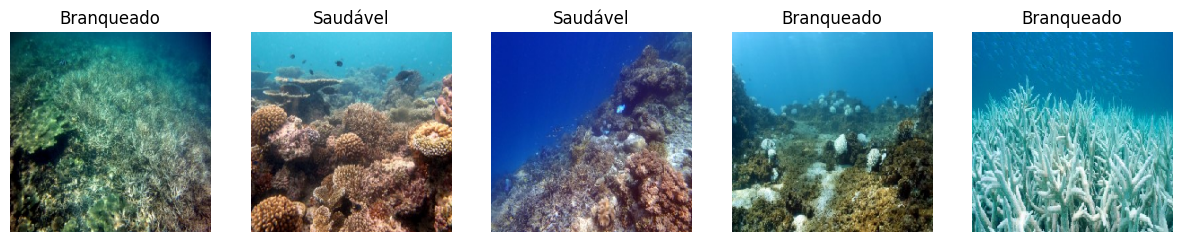

In [24]:
# prompt: create an script to display some of the images and their labels in the dataset (use random samples)

# Get a random sample of images and their labels
sample_images = image_df.sample(n=5)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(sample_images), figsize=(15, 5))

# Iterate through the sample images and display them with their labels
for i, (filepath, label) in enumerate(sample_images.values):
    # Load the image
    img = tensorflow.keras.preprocessing.image.load_img(filepath, target_size=TARGET_SIZE)

    # Convert the image to a NumPy array
    img_array = tensorflow.keras.preprocessing.image.img_to_array(img)

    # Normalize the image
    img_array = img_array / 255.0

    # Display the image
    axes[i].imshow(img_array)
    axes[i].set_title(label)
    axes[i].axis('off')

# Show the plot
plt.show()


# Pré-processamento

Preparando os dados.

In [25]:
# prompt: Split data for training and testing, and then create ImageDataGenerator objects for each one

# Dividindo os dados em treino e teste
train_df, test_df = train_test_split(image_df,test_size=0.2, shuffle=True, random_state=42)

# Criando os ImageDataGenerator
train_gen = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.vgg19.preprocess_input, validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.vgg19.preprocess_input)

# Gerando os dados de treino e teste
train_data = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Imagem',
    y_col='Diagnóstico',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Imagem',
    y_col='Diagnóstico',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = test_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Imagem',
    y_col='Diagnóstico',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
)

Found 590 validated image filenames belonging to 2 classes.
Found 147 validated image filenames belonging to 2 classes.
Found 185 validated image filenames belonging to 2 classes.


## Melhorando performance

Pré-processamento para lidar com cenários do mundo real.

In [26]:
augment = tensorflow.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

# VGG19

Modelo pré-treinado.

In [27]:
pretrained_model = tensorflow.keras.applications.vgg19.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

Criando callbacks para monitoramento do modelo.

In [28]:
# prompt: create a model checkpoint, early stopping and tensorboard callback

checkpointer = ModelCheckpoint(
    'corals_checkpoint',
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2, patience=3,
                              min_lr=1e-10)

callbacks = [checkpointer, early_stopping, reduce_lr]

# Treinamento do Modelo

Treinando o modelo.

In [33]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=70,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "corals_classification"),
        checkpointer,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/corals_classification/20240606-041519
Epoch 1/70
19/19 [==============================] - 6s 224ms/step - loss: 0.9406 - accuracy: 0.6153 - val_loss: 2.2316 - val_accuracy: 0.5034 - lr: 0.0010
Epoch 2/70
19/19 [==============================] - 4s 202ms/step - loss: 0.7514 - accuracy: 0.6864 - val_loss: 1.2018 - val_accuracy: 0.6054 - lr: 0.0010
Epoch 3/70
19/19 [==============================] - 4s 197ms/step - loss: 0.6154 - accuracy: 0.7441 - val_loss: 1.3766 - val_accuracy: 0.5578 - lr: 0.0010
Epoch 4/70
19/19 [==============================] - 5s 239ms/step - loss: 0.5787 - accuracy: 0.7644 - val_loss: 0.8377 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 5/70
19/19 [==============================] - 4s 205ms/step - loss: 0.4823 - accuracy: 0.7831 - val_loss: 0.9604 - val_accuracy: 0.6531 - lr: 0.0010
Epoch 6/70
19/19 [==============================] - 4s 208ms/step - loss: 0.4042 - accuracy: 0.8153 - val_loss: 0.8090 - val_accuracy: 0.673

# Avaliação do Modelo

Apresentando resultados.

In [34]:
results = model.evaluate(test_data, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.57686
Test Accuracy: 78.92%


O modelo apresenta uma precisão de 80.54%, atingindo um nível satisfatório para a operação.

## Testando

Realizando alguns testes.

1/1 [==============================] - 1s 1s/step
Predicted Class: Branqueado, Confidence: 0.9994382262229919


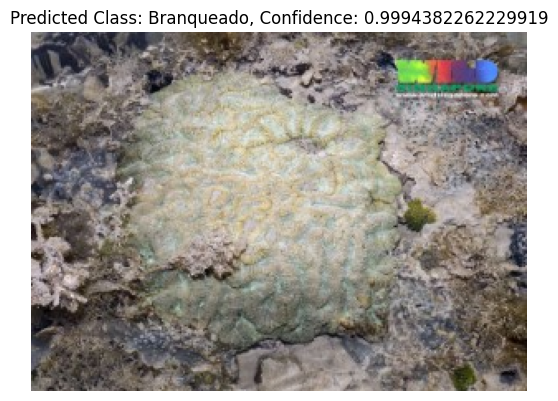

In [35]:
# Powered by ChatGPT

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescaling
    return img_array

# Function to make a prediction
def predict_image(model, img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    return predictions


# Example image path
img_path = '/content/dataset/bleached_corals/10033870215_3664757d59_o.jpg'

# Predict
predictions = predict_image(model, img_path)

# Assuming you have a binary classification with labels
class_labels = ['Branqueado', 'Saudável']

# Get the predicted class
predicted_class = class_labels[np.argmax(predictions)]
confidence = np.max(predictions)

# Print the result
print(f'Predicted Class: {predicted_class}, Confidence: {confidence}')

# Optionally, display the image
img = image.load_img(img_path)
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class}, Confidence: {confidence}')
plt.axis('off')
plt.show()

# Salvando modelo

Exportando a ideia.

In [37]:
with open('coral-ai.pickle', 'wb') as file:
    pickle.dump(model, file)

print('Modelo salvo com sucesso.')

Modelo salvo com sucesso.
